## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [3]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [4]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [5]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [6]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

In [7]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
# Test one of the folds first
fold_num = 'fold1'
fold = 1



print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

Test trials  4
Val trials 3
Test trials  8
Val trials 7
We are testing the optimization method on fold  1


## Model

In [35]:
import torch
import torch.nn as nn


class dev_model(nn.Module):
    def __init__(self,  hnet_output, 
                    num_features=124, 
                    hidden_units= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3, 
                    model_init = True):
        
        super(dev_model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size
        self.hnet_output = hnet_output
        self.out_features = out_dims

        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2)
        
        
        if model_init == False:
            # Initialize parameters with the outputs of hnet
            self.init_parameters()
            
        else:
            self.linear1 = nn.Linear(in_features=self.num_features, out_features= self.input_size)
            self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)

              

            self.lstm = nn.LSTM(
                            input_size= self.input_size,
                            hidden_size=hidden_units,
                            batch_first=True,
                            num_layers= num_layers,
                            bidirectional=False,)
            
            
    def init_parameters(self):
        # Assuming hnet_output is a list of tensors containing the parameters


        self.linear1 = nn.Linear(in_features=self.num_features, out_features= self.input_size)
        self.linear1.weight = nn.Parameter(self.hnet_output[0])
        self.linear1.bias = nn.Parameter(self.hnet_output[1])

        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=self.out_features)
        self.linear2.weight = nn.Parameter(self.hnet_output[2])
        self.linear2.bias = nn.Parameter(self.hnet_output[3])

        self.lstm = nn.LSTM(
                            input_size= self.input_size,
                            hidden_size= self.hidden_units,
                            batch_first=True,
                            num_layers= self.num_layers,
                            bidirectional=False,)
        # Set the weights and biases for the LSTM layer
        self.lstm.weight_ih_l0 = nn.Parameter(self.hnet_output[4])  # Set input-hidden weights
        self.lstm.weight_hh_l0 = nn.Parameter(self.hnet_output[5])  # Set hidden-hidden weights
        self.lstm.bias_ih_l0 = nn.Parameter(self.hnet_output[6])    # Set input-hidden biases
        self.lstm.bias_hh_l0 = nn.Parameter(self.hnet_output[7])    # Set hidden-hidden biases

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        self.lstm.flatten_parameters()  # Add this line to flatten parameters
        x, _ = self.lstm(x)
        x = self.dropout2(x)
        output = self.linear2(x)
        # Apply sigmoid activation function
        output = torch.sigmoid(output)
        
        return output.squeeze()
    


In [36]:
num_dim_output = y_train_base.shape[2]
num_features = x_train_base.shape[2]

# Hyperparameters LSTM class
hidden_units = 22
num_layers = 1
input_size = 50 #Not for now, only if I need a linear layer before the RNN

In [37]:
model = dev_model(num_features= num_features, hnet_output = 0, hidden_units = hidden_units,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, model_init = True).to(device)

In [38]:
param_shapes = [list(i.shape) for i in list(model.parameters())]

In [39]:
param_shapes

[[50, 127], [50], [3, 22], [3], [88, 50], [88, 22], [88], [88]]

In [40]:
param_names = [name for name, _ in model.named_parameters()]

for c, param in enumerate(model.parameters()):
    param.requires_grad = False

In [41]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[20], 
            num_cond_embs=num_conditions).to(device)

Created MLP Hypernet.
Hypernetwork with 272797 weights and 12981 outputs (compression ratio: 21.02).
The network consists of 272781 unconditional weights (272781 internally maintained) and 16 conditional weights (16 internally maintained).


In [42]:
weights_per_layer = [np.prod(i) for i in param_shapes ]

In [43]:
weights_per_layer

[6350, 50, 66, 3, 4400, 1936, 88, 88]

In [44]:
data_params = hnet.unconditional_params[-1]
param_old = 0
weights = []
for index, [params, p_shapes] in enumerate(zip(weights_per_layer,param_shapes)):
    weights.append(data_params[param_old:param_old+params].reshape(p_shapes))
    param_old += params

In [47]:
for param in hnet.parameters():
    param.requires_grad = True


""" # Initialize the model params
data_params = hnet.unconditional_params[-1]
param_old = 0
weights = []
for index, [params, p_shapes] in enumerate(zip(weights_per_layer,param_shapes)):
    weights.append(data_params[param_old:param_old+params].reshape(p_shapes))
    param_old += params """



# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr= 0.001)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=10, 
                                gamma=0.9)

# Keep track of the best model's parameters and loss
best_model_wts = deepcopy(model.state_dict())
best_loss = 1e8

# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

# Track the train and validation loss
train_losses = []
val_losses = []
# Counters for early stopping
not_increased = 0
end_train = 0


sequence_length_LSTM = 10
batch_size_train = batch_size_val = 25


# Reshape data for the LSTM
train_dataset_baseline = SequenceDataset(
y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

train_dataset_stim = SequenceDataset(
y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

val_dataset_baseline = SequenceDataset(
y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

val_dataset_stim = SequenceDataset(
y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)



# Loop through epochs
for epoch in np.arange(10):
    for phase in ['train', 'val']:
        # set model to train/validation as appropriate
        if phase == 'train':
            model.train()
            loaders = zip(loader_train_b, loader_train_s)
        else:
            model.eval()
            loaders = zip(loader_val_b, loader_val_s)

        # Initialize variables to track loss and batch size
        running_loss = 0
        running_size = 0        

        # Iterate over batches in the loader
        for data_b, data_s in loaders:

            # Define data for this batch
            x_b = data_b[0].to('cuda')
            y_b = data_b[1].to('cuda')
            x_s = data_s[0].to('cuda')
            y_s = data_s[1].to('cuda')

            if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)   
                        model = dev_model(num_features= num_features, hnet_output = W_base, hidden_units = hidden_units,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, model_init = False).to(device) 
                                         

                        """ for c, param in enumerate(model.parameters()):
                            param.data = torch.tensor(W_base[c], device = device) #torch.nn.Parameter(W_base[c].to(device), requires_grad=True)
                            param.requires_grad = True """
                            
                        """  print("Model Parameter {}: {} : {}".format(c, param.data.shape, param.requires_grad)) """
                        #torch.nn.Parameter(W_base[c].clone().to(device))
                        base_P = model(x_b)
                        loss_base = huber_loss(base_P, y_b, delta = 8)

                        loss_base.backward()
                        #print(hnet.unconditional_params[-1])
                        # Iterate over parameters of hnet and compute gradients
                        # Iterate over parameters of hnet and compute gradients
                       
                        for name, param in model.named_parameters():
                            if param.requires_grad:
                                print("Gradient for {}: {}".format(name, param.grad))
                         
                        optimizer.step()

           

Gradient for linear1.weight: tensor([[ 3.6314e-04,  4.3265e-04,  2.4659e-04,  ..., -8.9098e-05,
         -2.1034e-05, -2.5229e-04],
        [ 1.7005e-04, -1.8431e-04,  2.4472e-04,  ...,  1.5361e-04,
          5.7082e-05,  3.2844e-04],
        [-1.8055e-04,  5.4656e-04,  1.4897e-05,  ...,  9.3227e-05,
         -8.0797e-05,  4.6142e-04],
        ...,
        [-3.9171e-04, -4.4473e-04,  5.2194e-05,  ..., -7.6545e-04,
         -3.9044e-04, -3.6994e-04],
        [-2.8370e-04, -7.0072e-05, -2.5636e-04,  ..., -7.1441e-04,
         -3.4367e-04, -6.9349e-05],
        [-4.0580e-04,  2.2062e-04, -2.5449e-04,  ..., -6.6731e-04,
         -8.8743e-04, -6.4190e-04]], device='cuda:0')
Gradient for linear1.bias: tensor([ 3.0175e-04, -1.1979e-04, -4.6178e-04, -7.2959e-04,  6.3543e-04,
         4.7397e-04, -1.1972e-04,  1.2510e-04, -7.3090e-04,  1.9450e-04,
         5.6280e-04, -1.5322e-04, -1.5053e-04,  1.9150e-04, -4.6867e-05,
         1.3144e-04,  3.0289e-04,  1.8051e-04, -6.4427e-05, -7.1958e-04,
   

KeyboardInterrupt: 

In [35]:
# Loop through epochs
for epoch in np.arange(2):
    for phase in ['train', 'val']:
        # set model to train/validation as appropriate
        if phase == 'train':
            model.train()
            loaders = zip(loader_train_b, loader_train_s)
        else:
            model.eval()
            loaders = zip(loader_val_b, loader_val_s)

        # Initialize variables to track loss and batch size
        running_loss = 0
        running_size = 0        

        # Iterate over batches in the loader
        for data_b, data_s in loaders:

            # Define data for this batch
            x_b = data_b[0].to('cuda')
            y_b = data_b[1].to('cuda')
            x_s = data_s[0].to('cuda')
            y_s = data_s[1].to('cuda')

            if phase == "train":
                    with torch.set_grad_enabled(True):
                        
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)    
                                            
                        for c, param in enumerate(model.parameters()):
                            param.data = W_base[c].clone().detach().requires_grad_(True)
                        #torch.nn.Parameter(W_base[c].clone().to(device))
                        for p in model.parameters():
                             p.requires_grad = True
                        base_P = model(x_b)
                        loss_base = huber_loss(base_P, y_b, delta = 8)

                        loss_base.backward()
                        #print(hnet.unconditional_params[-1])
                        # Iterate over parameters of hnet and compute gradients
                        for param in model.parameters():
                             if param.requires_grad:
                                print("Gradient : {}".format(param.grad))
                        optimizer.step()

            

                        

Gradient : tensor([[ 0.0137, -0.0300,  0.0147,  ...,  0.0051,  0.0033, -0.0010],
        [-0.0366, -0.0097, -0.0040,  ..., -0.0075,  0.0125,  0.0273],
        [-0.0545, -0.1373, -0.0610,  ..., -0.0246, -0.0768, -0.0325],
        ...,
        [-0.0314, -0.0994, -0.0268,  ..., -0.0587, -0.0141,  0.0385],
        [ 0.0475,  0.0459,  0.0344,  ...,  0.0685,  0.0629,  0.0596],
        [-0.0442,  0.0429,  0.0905,  ..., -0.0406,  0.0648,  0.0117]],
       device='cuda:0')
Gradient : tensor([[-7.1494e-04, -1.2960e-03, -3.5389e-03,  ...,  1.6607e-03,
         -8.8621e-05,  1.4238e-03],
        [-1.0761e-03, -1.7621e-03,  4.0725e-04,  ..., -1.2519e-03,
          9.9303e-04, -8.5134e-04],
        [ 2.7994e-03,  4.4896e-04,  1.0256e-02,  ..., -1.9972e-03,
          3.7242e-03,  2.4605e-03],
        ...,
        [-1.4999e-04, -4.0410e-03, -5.8289e-03,  ..., -1.5607e-02,
          3.0425e-04,  1.2629e-02],
        [-2.3376e-03,  4.1675e-04, -1.4595e-02,  ...,  8.7465e-04,
         -7.7006e-03, -5.763

Gradient : tensor([[ 0.0141, -0.0298,  0.0151,  ...,  0.0052,  0.0037, -0.0008],
        [-0.0372, -0.0100, -0.0042,  ..., -0.0078,  0.0127,  0.0276],
        [-0.0555, -0.1396, -0.0617,  ..., -0.0247, -0.0776, -0.0329],
        ...,
        [-0.0313, -0.0998, -0.0267,  ..., -0.0596, -0.0138,  0.0386],
        [ 0.0479,  0.0469,  0.0349,  ...,  0.0698,  0.0644,  0.0605],
        [-0.0451,  0.0430,  0.0911,  ..., -0.0419,  0.0659,  0.0123]],
       device='cuda:0')
Gradient : tensor([[-0.0007, -0.0013, -0.0037,  ...,  0.0017, -0.0001,  0.0014],
        [-0.0011, -0.0018,  0.0004,  ..., -0.0013,  0.0010, -0.0009],
        [ 0.0028,  0.0003,  0.0104,  ..., -0.0021,  0.0038,  0.0024],
        ...,
        [-0.0001, -0.0041, -0.0061,  ..., -0.0157,  0.0002,  0.0127],
        [-0.0024,  0.0004, -0.0149,  ...,  0.0009, -0.0078, -0.0059],
        [-0.0068, -0.0042, -0.0111,  ...,  0.0031, -0.0049, -0.0092]],
       device='cuda:0')
Gradient : tensor([ 0.0293,  0.0014, -0.0547, -0.0089, -0.0063

In [24]:
hnet.internal_params[1]

Parameter containing:
tensor([ 0.1586, -0.5214, -2.6600, -0.6864, -1.2475, -0.7675, -0.6886,  0.4848],
       device='cuda:0', requires_grad=True)

In [20]:
def train_devtool(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = 3,
                batch_size_val = 3,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                chunks = False  ):

    for param in hnet.parameters():
        param.requires_grad = True

    # Set up the optimizer with the specified learning rate
    optimizer = torch.optim.Adam(hnet.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset_baseline = SequenceDataset(
    y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

    train_dataset_stim = SequenceDataset(
    y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

    val_dataset_baseline = SequenceDataset(
    y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

    val_dataset_stim = SequenceDataset(
    y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

    loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
    loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

    loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
    loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loaders = zip(loader_train_b, loader_train_s)
            else:
                model.eval()
                loaders = zip(loader_val_b, loader_val_s)

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for data_b, data_s in loaders:

                # Define data for this batch
                x_b = data_b[0].to('cuda')
                y_b = data_b[1].to('cuda')
                x_s = data_s[0].to('cuda')
                y_s = data_s[1].to('cuda')
               
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)    
                                            
                        for c, param in enumerate(model.parameters()):
                            param.data = W_base[c].clone().detach().requires_grad_(True)
                            param.requires_grad = True
                        #torch.nn.Parameter(W_base[c].clone().to(device))
                        base_P = model(x_b)
                        loss_base = huber_loss(base_P, y_b, delta = delta)
                        
                        
                        # Compute STIMULATION loss.
                        W_stim = hnet(cond_id=1)
                        for c, param in enumerate(model.parameters()):
                            param.data = torch.nn.Parameter(W_stim[c].clone().to(device))
                            param.requires_grad = True
                        stim_P = model(x_s)
                        loss_stim = huber_loss(stim_P, y_s, delta = delta)
                        
                        # Combine loss for 2 tasks
                        loss_t = loss_base + loss_stim    #only for printing

                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_stim_reg = loss_stim #+ regularizer(W_stim, l1_ratio, alpha)
                            loss_base_reg = loss_base #+ regularizer(W_base, l1_ratio, alpha)
                            # Combine loss for 2 tasks
                            loss_t_r = loss_base_reg + loss_stim_reg

                        else:               
                            loss_t_r = loss_t 
                        
                        

                        # Compute gradients and perform an optimization step
                        loss_t_r.backward()
                        optimizer.step()


                else:
                    # just compute the loss in validation phase
                    W_base = hnet(cond_id=0)
                    for c, param in enumerate(model.parameters()):
                        param.data = W_base[c].clone().to(device)
                        #torch.nn.Parameter(W_base[c].clone().to(device))
                    base_P = model(x_b)
                    base_P = torch.squeeze(base_P) #torch.sigmoid(base_P))
                    loss_base = huber_loss(base_P, y_b, delta = delta)

                    W_stim = hnet(cond_id=1)
                    for c, param in enumerate(model.parameters()):
                        param.data = W_stim[c].clone().to(device)
                        #torch.nn.Parameter(W_stim[c].clone().to(device))
                    stim_P = model(x_s)
                    stim_P = torch.squeeze(stim_P) #torch.sigmoid(stim_P))
                    loss_stim = huber_loss(stim_P, y_s, delta = delta)

                    loss_t = loss_base + loss_stim

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                assert torch.isfinite(loss_t_r)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses), W_base, W_stim
        # Update learning rate with the scheduler
        scheduler.step()
        
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), W_base, W_stim

In [21]:
hnet.internal_params[0].grad

In [22]:
#Hyperparameters objective and regularization
alpha_reg = 1e-7
l1_ratio_reg = 0.394

lr = 0.000001 # 0.00193
loss_function = huber_loss
delta = 7  # hyperparameter for huber loss



#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler


input_rec = 40
seq_length_LSTM = 16


batch_size_train= 30
batch_size_val = 30

In [23]:
train_losses, val_losses, W_base, W_stim = train_devtool(
                model, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.1,
                lr_step_size=10,
                lr_gamma=lr_gamma,
                sequence_length_LSTM= seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=5, 
                regularizer = reg_hnet_noweights, 
                l1_ratio = l1_ratio_reg,
                delta = 8,  
                alpha = alpha_reg, )

Epoch 000 Train 0.0816 Val 0.1070
Epoch 001 Train 0.0826 Val 0.1080
Epoch 002 Train 0.0817 Val 0.1074
Epoch 003 Train 0.0819 Val 0.1070
Epoch 004 Train 0.0824 Val 0.1073


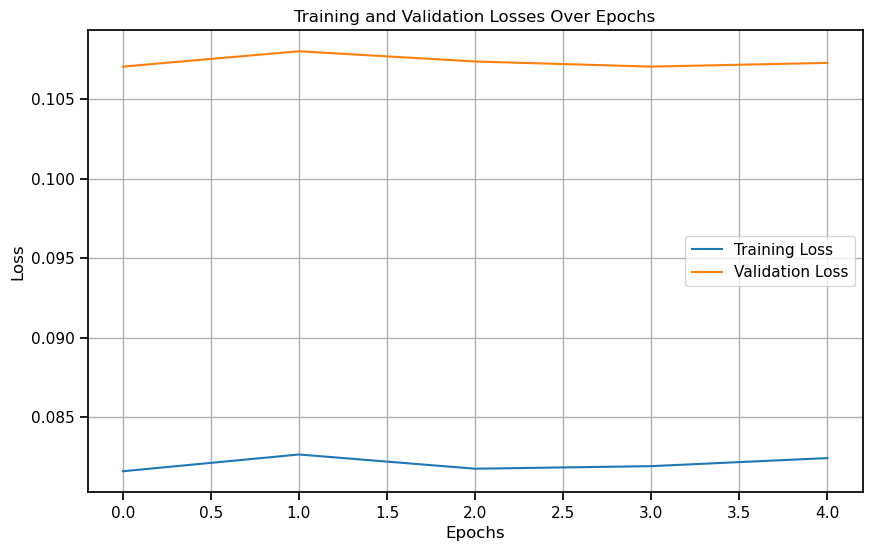

In [24]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [25]:
def calc_explained_variance(x, y, mnet, mnet_weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        # Forward pass to get predictions
        predictions = mnet(inputs)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        explained_var = explained_variance_score(y_true_2D, y_pred_2D)

    return explained_var

In [26]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [27]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, model, W_base)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  -0.3770383596420288
Explained variance for  Validation  is :  -0.17218124866485596
Explained variance for  Test  is :  -0.17860798041025797


In [28]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, model, W_stim)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  -0.49222572644551593
Explained variance for  Validation  is :  -0.15168688694636026
Explained variance for  Test  is :  -0.25227288405100506
